In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#load data from the shared drives to the colab
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/Shared drives/MACS Independent Research/3-Projects/chess player robot'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

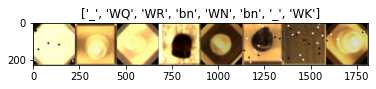

In [4]:
#Get a batch of training data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [7]:
#Define a function for executing the training
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
#download the model and set the model only tune the fully connected layers
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [8]:
#train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3715 Acc: 0.5274
val Loss: 0.2226 Acc: 0.9231

Epoch 1/24
----------
train Loss: 0.3599 Acc: 0.8930
val Loss: 0.1148 Acc: 0.9615

Epoch 2/24
----------
train Loss: 0.1953 Acc: 0.9425
val Loss: 0.1159 Acc: 0.9744

Epoch 3/24
----------
train Loss: 0.1577 Acc: 0.9584
val Loss: 0.0051 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0802 Acc: 0.9797
val Loss: 0.0250 Acc: 0.9872

Epoch 5/24
----------
train Loss: 0.0749 Acc: 0.9810
val Loss: 0.0018 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.0522 Acc: 0.9867
val Loss: 0.0013 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0236 Acc: 0.9938
val Loss: 0.0010 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0200 Acc: 0.9973
val Loss: 0.0006 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0185 Acc: 0.9969
val Loss: 0.0010 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0177 Acc: 0.9973
val Loss: 0.0005 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0144 Acc: 0.9987
val Loss: 0.0005 Acc: 1.0000

Ep

In [9]:
#view the model's prediction of the image in validation set 
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

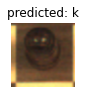

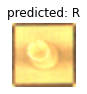

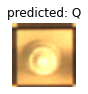

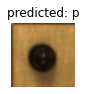

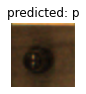

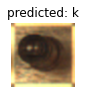

In [29]:
visualize_model(model_ft)

In [13]:
%cd /content/gdrive/Shared drives/MACS Independent Research/3-Projects/chess player robot/Testing
%ls

/content/gdrive/Shared drives/MACS Independent Research/3-Projects/chess player robot/Testing
start.png  state1.png  state2.png  state3.png  state4.png


In [14]:
square = {'H8': (572, 642, 373, 441), 'H7': (628, 698, 373, 441), 'H6': (684, 753, 373, 441), 'H5': (739, 805, 373, 441), 'H4': (791, 865, 373, 441), 'H3': (851, 921, 373, 441), 'H2': (907, 977, 373, 441), 'H1': (963, 1031, 373, 441), 'G8': (572, 642, 426, 497), 'G7': (628, 698, 426, 497), 'G6': (684, 753, 426, 497), 'G5': (739, 805, 426, 497), 'G4': (791, 865, 426, 497), 'G3': (851, 921, 426, 497), 'G2': (907, 977, 426, 497), 'G1': (963, 1031, 426, 497), 'F8': (572, 642, 482, 552), 'F7': (628, 698, 482, 552), 'F6': (684, 753, 482, 552), 'F5': (739, 805, 482, 552), 'F4': (791, 865, 482, 552), 'F3': (851, 921, 482, 552), 'F2': (907, 977, 482, 552), 'F1': (963, 1031, 482, 552), 'E8': (572, 642, 538, 604), 'E7': (628, 698, 538, 604), 'E6': (684, 753, 538, 604), 'E5': (739, 805, 538, 604), 'E4': (791, 865, 538, 604), 'E3': (851, 921, 538, 604), 'E2': (907, 977, 538, 604), 'E1': (963, 1031, 538, 604), 'D8': (572, 642, 594, 664), 'D7': (628, 698, 594, 664), 'D6': (684, 753, 594, 664), 'D5': (739, 805, 594, 664), 'D4': (791, 865, 594, 664), 'D3': (851, 921, 594, 664), 'D2': (907, 977, 594, 664), 'D1': (963, 1031, 594, 664), 'C8': (572, 642, 648, 720), 'C7': (628, 698, 648, 720), 'C6': (684, 753, 648, 720), 'C5': (739, 805, 648, 720), 'C4': (791, 865, 648, 720), 'C3': (851, 921, 648, 720), 'C2': (907, 977, 648, 720), 'C1': (963, 1031, 648, 720), 'B8': (572, 642, 703, 776), 'B7': (628, 698, 703, 776), 'B6': (684, 753, 703, 776), 'B5': (739, 805, 703, 776), 'B4': (791, 865, 703, 776), 'B3': (851, 921, 703, 776), 'B2': (907, 977, 703, 776), 'B1': (963, 1031, 703, 776), 'A8': (572, 642, 761, 830), 'A7': (628, 698, 761, 830), 'A6': (684, 753, 761, 830), 'A5': (739, 805, 761, 830), 'A4': (791, 865, 761, 830), 'A3': (851, 921, 761, 830), 'A2': (907, 977, 761, 830), 'A1': (963, 1031, 761, 830)}


In [15]:
processing = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [28]:
import cv2

class_names = ['B', 'K', 'N', 'P', 'Q', 'R', '_', 'b', 'k', 'n', 'p', 'q', 'r']
chessboard = np.zeros((8,8),dtype=str)
col = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}
row = {'1':7,'2':6,'3':5,'4':4,'5':3,'6':2,'7':1,'8':0}

image = cv2.imread('start.png',1)
image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
count = 0
for key,value in square.items():
  if count < 32:
    y1,y2,x1,x2 = value
    img = image[x1:x2,y1:y2,:]
    img_tt = processing(img)
    inputs = torch.stack((img_tt,img_tt,img_tt,img_tt),0)
    inputs = inputs.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs,1)
    chessboard[row[key[1]],col[key[0]]] = class_names[preds[0]]
    
print(chessboard)



[['r' 'n' 'b' 'q' 'q' 'b' 'n' 'r']
 ['b' 'p' 'p' 'p' 'p' 'p' 'p' 'p']
 ['_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_' '_' '_']
 ['B' 'P' 'P' 'B' 'P' 'P' 'B' 'P']
 ['R' 'N' 'B' 'Q' 'K' 'B' 'N' 'R']]
